## PROYECTO 1 - MINERIA DE DATOS

In [1]:
# Importando librerias necesarias
import pandas as pd
# Graficar
import matplotlib.pyplot as plt
# Verificar distribución normal
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm

In [2]:
# Cargando el data
data_2011 = pd.read_spss('matrimonio2011.sav')
data_2011 = pd.DataFrame(data_2011)

data_2012 = pd.read_spss('matrimonio2012.sav')
data_2012 = pd.DataFrame(data_2012)

data_2013 = pd.read_spss('matrimonio2013.sav')
data_2013 = pd.DataFrame(data_2013)

data_2014 = pd.read_spss('matrimonio2014.sav')
data_2014 = pd.DataFrame(data_2014)

data_2015 = pd.read_spss('matrimonio2015.sav')
data_2015 = pd.DataFrame(data_2015)

data_2016 = pd.read_spss('matrimonio2016.sav')
data_2016 = pd.DataFrame(data_2016)

data_2017 = pd.read_spss('matrimonio2017.sav')
data_2017 = pd.DataFrame(data_2017)

data_2018 = pd.read_spss('matrimonio2018.sav')
data_2018 = pd.DataFrame(data_2018)

data_2019 = pd.read_spss('matrimonio2019.sav')
data_2019 = pd.DataFrame(data_2019)

data_2020 = pd.read_spss('matrimonio2020.sav')
data_2020 = pd.DataFrame(data_2020)

data_2021 = pd.read_spss('matrimonio2021.sav')
data_2021 = pd.DataFrame(data_2021)


In [3]:
from utils import *

# Data de importancia
ocupacion_tipos_basico = get_ocupaciones_info()

departamentos_2011_2019 = {'Alta Verapaz': 1, 'Baja Verapaz': 2, 'Chimaltenango': 3, 'Chiquimula': 4, 'El Progreso': 5, 'Escuintla': 6, 'Guatemala': 7,
                           'Huehuetenango': 8, 'Izabal': 9, 'Jalapa': 10, 'Jutiapa': 11, 'Peten': 12, 'Quetzaltenango': 13, 'Quiche': 14, 'Retalhuleu': 15,
                           'Sacatepequez': 16, 'San Marcos': 17, 'Santa Rosa': 18, 'Solola': 19, 'Suchitepequez': 20, 'Totonicapan': 21, 'Zacapa': 22}

meses_ocurrencia = {'Enero':1, 'Febrero':2, 'Marzo':3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 
                    'Noviembre': 11, 'Diciembre': 12}


In [4]:
# Limpieza data - 2011

columns_use_2011 = []

# Accediendo a códigos de ocupación de hombre y mujer
code_data_2011 = pd.read_spss('matrimonio2011.sav', convert_categoricals=False)
code_data_2011 = pd.DataFrame(code_data_2011)

# Renombrando columnas
code_data_2011.rename(columns={'Ocumuj': 'ocupacionMujer'}, inplace=True)
code_data_2011.rename(columns={'Ocuhom': 'ocupacionHombre'}, inplace=True)

# Mapeando códigos de ocupación a nombres de ocupación
code_data_2011['ocupacionMujer'] = code_data_2011['ocupacionMujer'].apply(map_code)
code_data_2011['ocupacionHombre'] = code_data_2011['ocupacionHombre'].apply(map_code)

# Agregando columnas de ocupación a data
data_2011 = data_2011.assign(ocupacionHombre=code_data_2011['ocupacionHombre'], ocupacionMujer=code_data_2011['ocupacionMujer'])
columns_use_2011.extend(['ocupacionHombre', 'ocupacionMujer'])

# Uso de data solamente de personas guatemaltecas
data_2011 = data_2011[data_2011['Nachom'] == 'Guatemala']
data_2011 = data_2011[data_2011['Nacmuj'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2011 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2011['claseUnion'] = data_2011['Clauni'].apply(lambda x: union_tipos_2011.get(x, 0))
columns_use_2011.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2011 = {'No indigena': 1, 'Indigena': 2}
data_2011['grupoEtnicoHombre'] = data_2011['Gethom'].apply(lambda x: grupos_etnicos_2011.get(x, 0))
data_2011['grupoEtnicoMujer'] = data_2011['Getmuj'].apply(lambda x: grupos_etnicos_2011.get(x, 0))
columns_use_2011.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre 
data_2011['edadHombre'] = data_2011['Edadhom']
columns_use_2011.append('edadHombre')

# Edad de la mujer
data_2011['edadMujer'] = data_2011['Edadmuj']
columns_use_2011.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2011 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5}
data_2011['educacionHombre'] = data_2011['Eschom'].apply(lambda x: educacion_tipos_2011.get(x, 0))
data_2011['educacionMujer'] = data_2011['Escmuj'].apply(lambda x: educacion_tipos_2011.get(x, 0))
columns_use_2011.extend(['educacionHombre', 'educacionMujer'])

# Departamento de ocurrencia de matrimonio
data_2011['departamentoOcurrencia'] = data_2011['Depreg'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2011.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2011['mesOcurrencia'] = data_2011['Mesreg'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2011.append('mesOcurrencia')

# Año de registro de matrimonio
data_2011['anioRegistro'] = data_2011['Añoreg']
columns_use_2011.append('anioRegistro')

# data final - 2011
columns_not_used = [x for x in data_2011.columns if x not in columns_use_2011]
data_2011_final = data_2011.drop(columns_not_used, axis=1)

data_2011_final


,ocupacionHombre,ocupacionMujer,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
1,15,15,3,0,0,29.0,31.0,1,1,7,1,2012.0
2,20,0,1,2,0,21.0,17.0,0,1,21,12,2011.0
3,28,6,3,0,0,58.0,53.0,1,1,7,11,2011.0
4,6,6,1,1,1,31.0,24.0,5,4,7,11,2011.0
5,8,6,1,1,1,27.0,25.0,4,4,18,1,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...
78281,0,0,1,0,0,15.0,15.0,0,0,14,7,2011.0
78282,0,0,1,0,0,17.0,14.0,0,0,14,7,2011.0
78283,0,0,1,0,0,17.0,16.0,0,0,14,8,2011.0
78284,0,0,1,0,0,18.0,18.0,0,0,14,10,2011.0


In [5]:
# Limpieza data - 2012

columns_use_2012 = []

# Accediendo a códigos de ocupación de hombre y mujer
code_data_2012 = pd.read_spss('matrimonio2012.sav', convert_categoricals=False)
code_data_2012 = pd.DataFrame(code_data_2012)

# Renombrando columnas
code_data_2012.rename(columns={'OCUMUJ': 'ocupacionMujer'}, inplace=True)
code_data_2012.rename(columns={'OCUHOM': 'ocupacionHombre'}, inplace=True)

# Mapeando códigos de ocupación a nombres de ocupación
code_data_2012['ocupacionMujer'] = code_data_2012['ocupacionMujer'].apply(map_code)
code_data_2012['ocupacionHombre'] = code_data_2012['ocupacionHombre'].apply(map_code)

# Agregando columnas de ocupación a data
data_2012 = data_2012.assign(ocupacionHombre=code_data_2012['ocupacionHombre'], ocupacionMujer=code_data_2012['ocupacionMujer'])
columns_use_2012.extend(['ocupacionHombre', 'ocupacionMujer'])

# Uso de data solamente de personas guatemaltecas
data_2012 = data_2012[data_2012['NACHOM'] == 'Guatemala']
data_2012 = data_2012[data_2012['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2012 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2012['claseUnion'] = data_2012['CLAUNI'].apply(lambda x: union_tipos_2012.get(x, 0))
columns_use_2012.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2012 = {'No indigena': 1, 'Indigena': 2}
data_2012['grupoEtnicoHombre'] = data_2012['GETHOM'].apply(lambda x: grupos_etnicos_2012.get(x, 0))
data_2012['grupoEtnicoMujer'] = data_2012['GETMUJ'].apply(lambda x: grupos_etnicos_2012.get(x, 0))
columns_use_2012.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2012['edadHombre'] = data_2012['EDADHOM']
columns_use_2012.append('edadHombre')

# Edad de la mujer
data_2012['edadMujer'] = data_2012['EDADMUJ']
columns_use_2012.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2012 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5}
data_2012['educacionHombre'] = data_2012['ESCHOM'].apply(lambda x: educacion_tipos_2012.get(x, 0))
data_2012['educacionMujer'] = data_2012['ESCMUJ'].apply(lambda x: educacion_tipos_2012.get(x, 0))
columns_use_2012.extend(['educacionHombre', 'educacionMujer'])

# Departamento de ocurrencia de matrimonio
data_2012['departamentoOcurrencia'] = data_2012['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2012.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2012['mesOcurrencia'] = data_2012['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2012.append('mesOcurrencia')

# Año de registro de matrimonio
data_2012['anioRegistro'] = data_2012['AÑOREG']
columns_use_2012.append('anioRegistro')

# data final - 2012
columns_not_used_2012 = [x for x in data_2012.columns if x not in columns_use_2012]
data_2012_final = data_2012.drop(columns_not_used_2012, axis=1)

data_2012_final


,ocupacionHombre,ocupacionMujer,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
3,11,6,1,1,1,29.0,30.0,5,5,7,3,2013.0
5,31,6,3,2,1,39.0,38.0,5,5,7,1,2013.0
6,8,6,1,1,1,25.0,23.0,4,4,7,12,2012.0
7,39,6,1,1,1,32.0,31.0,4,4,4,7,2012.0
9,1,6,3,1,1,27.0,35.0,3,4,7,3,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84242,0,0,1,0,0,74.0,69.0,0,0,17,6,2012.0
84243,0,0,1,0,0,73.0,71.0,0,0,6,9,2012.0
84244,0,0,1,0,0,77.0,73.0,0,0,6,1,2013.0
84245,0,0,1,0,0,83.0,79.0,0,0,7,9,2012.0


In [6]:
# Limpieza data - 2013

columns_use_2013 = []

# Uso de data solamente de personas guatemaltecas
data_2013 = data_2013[data_2013['NACHOM'] == 'Guatemala']
data_2013 = data_2013[data_2013['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2013 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2013['claseUnion'] = data_2013['CLAUNI'].apply(lambda x: union_tipos_2013.get(x, 0))
columns_use_2013.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2013 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2013['grupoEtnicoHombre'] = data_2013['PUEHOM'].apply(lambda x: grupos_etnicos_2013.get(x, 0))
data_2013['grupoEtnicoMujer'] = data_2013['PUEMUJ'].apply(lambda x: grupos_etnicos_2013.get(x, 0))
columns_use_2013.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2013['edadHombre'] = data_2013['EDADHOM']
columns_use_2013.append('edadHombre')

# Edad de la mujer
data_2013['edadMujer'] = data_2013['EDADMUJ']
columns_use_2013.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2013 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'DIversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2013['educacionHombre'] = data_2013['ESCHOM'].apply(lambda x: educacion_tipos_2013.get(x, 0))
data_2013['educacionMujer'] = data_2013['ESCMUJ'].apply(lambda x: educacion_tipos_2013.get(x, 0))
columns_use_2013.extend(['educacionHombre', 'educacionMujer'])

# Ocupaciones extra del hombre 
mas_ocupaciones = ocupacion_tipos_basico.copy()
mas_ocupaciones['Suboficiales de las fuerzas armadas'] = 22
mas_ocupaciones['Trabajadores forestales calificados, pescadores y cazadores'] = 41

# Ocupacion del hombre y de la mujer
data_2013['ocupacionHombre'] = data_2013['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
data_2013['ocupacionMujer'] = data_2013['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2013.extend(['ocupacionHombre', 'ocupacionMujer'])

# Departamento de ocurrencia de matrimonio
data_2013['departamentoOcurrencia'] = data_2013['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2013.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2013['mesOcurrencia'] = data_2013['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2013.append('mesOcurrencia')

# Año de registro de matrimonio
data_2013['anioRegistro'] = data_2013['AÑOREG']
columns_use_2013.append('anioRegistro')

# data final - 2013
columns_not_used_2013 = [x for x in data_2013.columns if x not in columns_use_2013]
data_2013_final = data_2013.drop(columns_not_used_2013, axis=1)

data_2013_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,1,1,22.0,22.0,2,0,1,27,7,8,2013.0
1,1,0,0,17.0,16.0,0,0,36,36,3,3,2013.0
2,1,1,1,38.0,32.0,0,1,36,14,10,8,2013.0
3,0,2,2,18.0,18.0,0,2,36,14,3,5,2013.0
4,1,2,2,21.0,17.0,2,1,36,14,19,11,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80745,0,0,2,40.0,37.0,0,2,0,14,8,5,2013.0
80746,1,1,1,17.0,18.0,0,2,0,14,20,2,2013.0
80747,1,0,2,22.0,20.0,0,2,0,14,14,9,2013.0
80748,1,0,2,28.0,22.0,0,2,0,14,14,9,2013.0


In [7]:
# Limpieza data - 2014

columns_use_2014 = []

# Uso de data solamente de personas guatemaltecas
data_2014 = data_2014[data_2014['NACHOM'] == 'Guatemala']
data_2014 = data_2014[data_2014['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2014 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2014['claseUnion'] = data_2014['CLAUNI'].apply(lambda x: union_tipos_2014.get(x, 0))
columns_use_2014.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2014 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2014['grupoEtnicoHombre'] = data_2014['PUEHOM'].apply(lambda x: grupos_etnicos_2014.get(x, 0))
data_2014['grupoEtnicoMujer'] = data_2014['PUEMUJ'].apply(lambda x: grupos_etnicos_2014.get(x, 0))
columns_use_2014.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2014['edadHombre'] = data_2014['EDADHOM']
columns_use_2014.append('edadHombre')

# Edad de la mujer
data_2014['edadMujer'] = data_2014['EDADMUJ']
columns_use_2014.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2014 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'DIversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2014['educacionHombre'] = data_2014['ESCHOM'].apply(lambda x: educacion_tipos_2014.get(x, 0))
data_2014['educacionMujer'] = data_2014['ESCMUJ'].apply(lambda x: educacion_tipos_2014.get(x, 0))
columns_use_2014.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2014['ocupacionHombre'] = data_2014['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2014.append('ocupacionHombre')

# Oficio de la mujer
data_2014['ocupacionMujer'] = data_2014['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2014.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2014['departamentoOcurrencia'] = data_2014['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2014.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2014['mesOcurrencia'] = data_2014['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2014.append('mesOcurrencia')

# Año de registro de matrimonio
data_2014['anioRegistro'] = data_2014['AÑOREG']
columns_use_2014.append('anioRegistro')

# data final - 2014
columns_not_used_2014 = [x for x in data_2014.columns if x not in columns_use_2014]
data_2014_final = data_2014.drop(columns_not_used_2014, axis=1)

data_2014_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,0,0,15.0,13.0,1,1,14,14,8,2,2014.0
1,1,2,0,18.0,13.0,1,1,39,14,14,12,2014.0
2,1,2,0,18.0,13.0,1,1,1,14,20,1,2014.0
3,1,1,0,19.0,13.0,1,1,1,14,10,2,2014.0
4,1,1,0,20.0,13.0,4,1,14,14,17,8,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
79489,1,1,0,29.0,Ignorado,4,0,8,14,11,5,2014.0
79490,1,1,0,33.0,Ignorado,2,0,1,14,11,1,2015.0
79491,1,1,0,39.0,Ignorado,2,0,1,14,11,5,2014.0
79493,1,0,0,Ignorado,Ignorado,0,0,1,14,11,9,2014.0


In [8]:
# Limpieza data - 2015

columns_use_2015 = []

# Uso de data solamente de personas guatemaltecas
data_2015 = data_2015[data_2015['NACHOM'] == 'Guatemala']
data_2015 = data_2015[data_2015['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2015 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2015['claseUnion'] = data_2015['CLAUNI'].apply(lambda x: union_tipos_2015.get(x, 0))
columns_use_2015.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2015 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2015['grupoEtnicoHombre'] = data_2015['PUEHOM'].apply(lambda x: grupos_etnicos_2015.get(x, 0))
data_2015['grupoEtnicoMujer'] = data_2015['PUEMUJ'].apply(lambda x: grupos_etnicos_2015.get(x, 0))
columns_use_2015.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2015['edadHombre'] = data_2015['EDADHOM']
columns_use_2015.append('edadHombre')

# Edad de la mujer
data_2015['edadMujer'] = data_2015['EDADMUJ']
columns_use_2015.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2015 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2015['educacionHombre'] = data_2015['ESCHOM'].apply(lambda x: educacion_tipos_2015.get(x, 0))
data_2015['educacionMujer'] = data_2015['ESCMUJ'].apply(lambda x: educacion_tipos_2015.get(x, 0))
columns_use_2015.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2015['ocupacionHombre'] = data_2015['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2015.append('ocupacionHombre')

# Oficio de la mujer
data_2015['ocupacionMujer'] = data_2015['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2015.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2015['departamentoOcurrencia'] = data_2015['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2015.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2015['mesOcurrencia'] = data_2015['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2015.append('mesOcurrencia')

# Año de registro de matrimonio
data_2015['anioRegistro'] = data_2015['AÑOREG']
columns_use_2015.append('anioRegistro')

# data final - 2015
columns_not_used_2015 = [x for x in data_2015.columns if x not in columns_use_2015]
data_2015_final = data_2015.drop(columns_not_used_2015, axis=1)

data_2015_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,1,1,34.0,32.0,4,5,14,34,7,8,2015.0
1,1,2,1,28.0,29.0,2,4,14,14,3,7,2015.0
2,1,1,1,30.0,22.0,4,3,14,14,17,7,2015.0
3,1,2,2,58.0,54.0,1,1,1,14,8,1,2015.0
4,1,2,2,31.0,28.0,2,3,1,14,1,1,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...
79172,1,2,2,32.0,26.0,4,2,26,14,8,4,2016.0
79173,1,2,2,23.0,31.0,0,1,1,14,8,3,2016.0
79174,1,2,2,27.0,31.0,0,2,1,14,8,4,2016.0
79175,1,2,2,34.0,34.0,1,1,1,14,8,4,2016.0


In [9]:
# Limpieza data - 2016

columns_use_2016 = []

# Uso de data solamente de personas guatemaltecas
data_2016 = data_2016[data_2016['NACHOM'] == 'Guatemala']
data_2016 = data_2016[data_2016['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2016 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2016['claseUnion'] = data_2016['CLAUNI'].apply(lambda x: union_tipos_2016.get(x, 0))
columns_use_2016.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2016 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2016['grupoEtnicoHombre'] = data_2016['PUEHOM'].apply(lambda x: grupos_etnicos_2016.get(x, 0))
data_2016['grupoEtnicoMujer'] = data_2016['PUEMUJ'].apply(lambda x: grupos_etnicos_2016.get(x, 0))
columns_use_2016.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2016['edadHombre'] = data_2016['EDADHOM']
columns_use_2016.append('edadHombre')

# Edad de la mujer
data_2016['edadMujer'] = data_2016['EDADMUJ']
columns_use_2016.append('edadMujer')

educacion_tipos_2016 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2016['educacionHombre'] = data_2016['ESCHOM'].apply(lambda x: educacion_tipos_2016.get(x, 0))
data_2016['educacionMujer'] = data_2016['ESCMUJ'].apply(lambda x: educacion_tipos_2016.get(x, 0))
columns_use_2016.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2016['ocupacionHombre'] = data_2016['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2016.append('ocupacionHombre')

# Oficio de la mujer
data_2016['ocupacionMujer'] = data_2016['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2016.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2016['departamentoOcurrencia'] = data_2016['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2016.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2016['mesOcurrencia'] = data_2016['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2016.append('mesOcurrencia')

# Año de registro de matrimonio
data_2016['anioRegistro'] = data_2016['AÑOREG']
columns_use_2016.append('anioRegistro')

# data final - 2016
columns_not_used_2016 = [x for x in data_2016.columns if x not in columns_use_2016]
data_2016_final = data_2016.drop(columns_not_used_2016, axis=1)

data_2016_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
222,1,0,1,24.0,18.0,1,2,23,14,4,1,2016.0
223,1,1,1,22.0,19.0,2,3,23,14,18,1,2016.0
224,1,1,1,33.0,33.0,4,4,8,8,7,1,2016.0
225,1,1,1,29.0,26.0,4,2,32,14,11,1,2016.0
226,1,2,2,21.0,19.0,1,3,23,14,4,1,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69011,1,1,1,22.0,21.0,2,3,23,14,8,6,2017.0
69012,1,1,1,46.0,43.0,1,1,16,14,7,6,2017.0
69013,1,1,1,21.0,25.0,3,4,14,14,18,6,2017.0
69014,1,2,0,28.0,20.0,2,3,23,14,2,6,2017.0


In [10]:
# Limpieza data - 2017

columns_use_2017 = []

# Uso de data solamente de personas guatemaltecas
data_2017 = data_2017[data_2017['NACHOM'] == 'Guatemala']
data_2017 = data_2017[data_2017['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2017 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2017['claseUnion'] = data_2017['CLAUNI'].apply(lambda x: union_tipos_2017.get(x, 0))
columns_use_2017.append('claseUnion')

# Grupo etnico de hombre
grupos_etnicos_hombre_2017 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 2, 'Xinca': 2}
data_2017['grupoEtnicoHombre'] = data_2017['PUEHOM'].apply(lambda x: grupos_etnicos_hombre_2017.get(x, 0))
columns_use_2017.append('grupoEtnicoHombre')

# Grupo etnico de mujer
grupos_etnicos_mujer_2017 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 2, 'Xinca': 2}
data_2017['grupoEtnicoMujer'] = data_2017['PUEMUJ'].apply(lambda x: grupos_etnicos_mujer_2017.get(x, 0))
columns_use_2017.append('grupoEtnicoMujer')

# Edad del hombre
data_2017['edadHombre'] = data_2017['EDADHOM']
columns_use_2017.append('edadHombre')

# Edad de la mujer
data_2017['edadMujer'] = data_2017['EDADMUJ']
columns_use_2017.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2017 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2017['educacionHombre'] = data_2017['ESCHOM'].apply(lambda x: educacion_tipos_2017.get(x, 0))
data_2017['educacionMujer'] = data_2017['ESCMUJ'].apply(lambda x: educacion_tipos_2017.get(x, 0))
columns_use_2017.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2017['ocupacionHombre'] = data_2017['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2017.append('ocupacionHombre')

# Oficio de la mujer
data_2017['ocupacionMujer'] = data_2017['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2017.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2017['departamentoOcurrencia'] = data_2017['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2017.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2017['mesOcurrencia'] = data_2017['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2017.append('mesOcurrencia')

# Año de registro de matrimonio
data_2017['anioRegistro'] = data_2017['AÑOREG']
columns_use_2017.append('anioRegistro')

# data final - 2017
columns_not_used_2017 = [x for x in data_2017.columns if x not in columns_use_2017]
data_2017_final = data_2017.drop(columns_not_used_2017, axis=1)

data_2017_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,0,0,19.0,19.0,0,0,0,0,14,9,2017.0
1,1,0,0,19.0,19.0,0,0,0,0,14,4,2017.0
2,1,0,0,19.0,19.0,0,0,0,0,14,4,2017.0
3,1,0,0,18.0,19.0,0,0,0,0,19,5,2017.0
4,1,0,0,18.0,19.0,0,0,0,0,21,2,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71591,1,1,1,50.0,42.0,4,5,31,6,7,6,2017.0
71592,2,1,1,22.0,21.0,4,5,29,6,7,2,2017.0
71594,3,0,1,25.0,25.0,5,5,6,6,7,1,2018.0
71595,1,0,1,26.0,26.0,4,4,14,22,16,1,2018.0


In [11]:
# Limpieza data - 2018

columns_use_2018 = []

# Uso de data solamente de personas guatemaltecas
data_2018 = data_2018[data_2018['NACHOM'] == 'Guatemala']
data_2018 = data_2018[data_2018['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2018 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2018['claseUnion'] = data_2018['CLAUNI'].apply(lambda x: union_tipos_2018.get(x, 0))
columns_use_2018.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2018 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 2, 'Xinca': 2}
data_2018['grupoEtnicoHombre'] = data_2018['PUEHOM'].apply(lambda x: grupos_etnicos_2018.get(x, 0))
data_2018['grupoEtnicoMujer'] = data_2018['PUEMUJ'].apply(lambda x: grupos_etnicos_2018.get(x, 0))
columns_use_2018.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2018['edadHombre'] = data_2018['EDADHOM']
columns_use_2018.append('edadHombre')

# Edad de la mujer
data_2018['edadMujer'] = data_2018['EDADMUJ']
columns_use_2018.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2018 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2018['educacionHombre'] = data_2018['ESCHOM'].apply(lambda x: educacion_tipos_2018.get(x, 0))
data_2018['educacionMujer'] = data_2018['ESCMUJ'].apply(lambda x: educacion_tipos_2018.get(x, 0))
columns_use_2018.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2018['ocupacionHombre'] = data_2018['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2018.append('ocupacionHombre')

# Oficio de la mujer
data_2018['ocupacionMujer'] = data_2018['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2018.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2018['departamentoOcurrencia'] = data_2018['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2018.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2018['mesOcurrencia'] = data_2018['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2018.append('mesOcurrencia')

# Año de registro de matrimonio
data_2018['anioRegistro'] = data_2018['AÑOREG']
columns_use_2018.append('anioRegistro')

# data final - 2018
columns_not_used_2018 = [x for x in data_2018.columns if x not in columns_use_2018]
data_2018_final = data_2018.drop(columns_not_used_2018, axis=1)

data_2018_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
1,2,1,1,30.0,31.0,4,4,14,31,7,1,2018.0
2,1,1,1,59.0,51.0,1,1,39,39,7,1,2018.0
3,3,2,2,25.0,23.0,4,4,14,39,7,1,2018.0
5,1,1,1,26.0,20.0,4,4,31,31,7,1,2018.0
6,1,0,1,49.0,23.0,2,3,14,14,7,1,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...
74771,1,1,1,23.0,27.0,1,3,23,14,11,1,2019.0
74772,1,1,0,23.0,21.0,3,2,14,14,11,1,2019.0
74773,2,1,1,18.0,18.0,3,4,23,14,11,1,2019.0
74774,1,1,1,37.0,20.0,4,4,32,14,11,1,2019.0


In [12]:
# Limpieza data - 2019

columns_use_2019 = []

# Uso de data solamente de personas guatemaltecas
data_2019 = data_2019[data_2019['NACHOM'] == 'Guatemala']
data_2019 = data_2019[data_2019['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2019 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2019['claseUnion'] = data_2019['CLAUNI'].apply(lambda x: union_tipos_2019.get(x, 0))
columns_use_2019.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2019 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 2, 'Xinca': 2}
data_2019['grupoEtnicoHombre'] = data_2019['PUEHOM'].apply(lambda x: grupos_etnicos_2019.get(x, 0))
data_2019['grupoEtnicoMujer'] = data_2019['PUEMUJ'].apply(lambda x: grupos_etnicos_2019.get(x, 0))
columns_use_2019.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2019['edadHombre'] = data_2019['EDADHOM']
columns_use_2019.append('edadHombre')

# Edad de la mujer
data_2019['edadMujer'] = data_2019['EDADMUJ']
columns_use_2019.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2019 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2019['educacionHombre'] = data_2019['ESCHOM'].apply(lambda x: educacion_tipos_2019.get(x, 0))
data_2019['educacionMujer'] = data_2019['ESCMUJ'].apply(lambda x: educacion_tipos_2019.get(x, 0))
columns_use_2019.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2019['ocupacionHombre'] = data_2019['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2019.append('ocupacionHombre')

# Oficio de la mujer
data_2019['ocupacionMujer'] = data_2019['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2019.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2019['departamentoOcurrencia'] = data_2019['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2019.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2019['mesOcurrencia'] = data_2019['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2019.append('mesOcurrencia')

# Año de registro de matrimonio
data_2019['anioRegistro'] = data_2019['AÑOREG']
columns_use_2019.append('anioRegistro')

# data final - 2019
columns_not_used_2019 = [x for x in data_2019.columns if x not in columns_use_2019]
data_2019_final = data_2019.drop(columns_not_used_2019, axis=1)

data_2019_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,1,1,28.0,35.0,4,5,14,15,7,9,2019.0
1,2,1,1,26.0,27.0,4,4,25,15,10,8,2019.0
2,1,1,1,47.0,31.0,6,5,14,6,7,9,2019.0
3,1,0,1,26.0,36.0,3,5,14,6,7,12,2019.0
5,1,1,1,32.0,36.0,5,5,14,6,1,8,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76922,1,1,0,34.0,26.0,4,0,26,0,6,12,2019.0
76924,1,2,0,30.0,28.0,4,0,26,0,14,9,2019.0
76925,1,1,0,30.0,29.0,4,0,26,0,7,1,2020.0
76926,1,1,1,44.0,39.0,5,4,28,0,4,12,2019.0


In [13]:

departamentos_2020_2021 = {'Alta Verapaz': 1, 'Baja Verapaz': 2, 'Chimaltenango': 3, 'Chiquimula': 4, 'El Progreso': 5, 'Escuintla': 6, 'Guatemala': 7, 'Huehuetenango': 8,
                            'Izabal': 9, 'Jalapa': 10, 'Jutiapa': 11, 'Petén': 12, 'Quetzaltenango': 13, 'Quiché': 14, 'Retalhuleu': 15, 'Sacatepéquez': 16, 'San Marcos': 17,
                            'Santa Rosa': 18, 'Sololá': 19, 'Suchitepéquez': 20, 'Totonicapán': 21, 'Zacapa': 22}


In [14]:
# Limpieza data - 2020

columns_use_2020 = []

# Uso de data solamente de personas guatemaltecas
data_2020 = data_2020[data_2020['NACHOM'] == 'Guatemala']
data_2020 = data_2020[data_2020['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2020 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2020['claseUnion'] = data_2020['CLAUNI'].apply(lambda x: union_tipos_2020.get(x, 0))
columns_use_2020.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2020 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2020['grupoEtnicoHombre'] = data_2020['PUEHOM'].apply(lambda x: grupos_etnicos_2020.get(x, 0))
data_2020['grupoEtnicoMujer'] = data_2020['PUEMUJ'].apply(lambda x: grupos_etnicos_2020.get(x, 0))
columns_use_2020.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2020['edadHombre'] = data_2020['EDADHOM']
columns_use_2020.append('edadHombre')

# Edad de la mujer
data_2020['edadMujer'] = data_2020['EDADMUJ']
columns_use_2020.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2020 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2020['educacionHombre'] = data_2020['ESCHOM'].apply(lambda x: educacion_tipos_2020.get(x, 0))
data_2020['educacionMujer'] = data_2020['ESCMUJ'].apply(lambda x: educacion_tipos_2020.get(x, 0))
columns_use_2020.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2020['ocupacionHombre'] = data_2020['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2020.append('ocupacionHombre')

# Oficio de la mujer
data_2020['ocupacionMujer'] = data_2020['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2020.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2020['departamentoOcurrencia'] = data_2020['DEPREG'].apply(lambda x: departamentos_2020_2021.get(x, 0))
columns_use_2020.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2020['mesOcurrencia'] = data_2020['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2020.append('mesOcurrencia')

# Año de registro de matrimonio
data_2020['anioRegistro'] = data_2020['AÑOREG']
columns_use_2020.append('anioRegistro')

# data final - 2020
columns_not_used_2020 = [x for x in data_2020.columns if x not in columns_use_2020]
data_2020_final = data_2020.drop(columns_not_used_2020, axis=1)

data_2020_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,1,1,33.0,33.0,4,4,15,15,7,2,2021.0
1,1,0,1,30.0,31.0,4,4,15,15,7,4,2021.0
3,1,1,1,27.0,34.0,4,5,14,5,7,8,2020.0
4,1,1,1,54.0,47.0,3,5,14,5,7,8,2020.0
6,1,1,1,29.0,42.0,4,0,14,5,7,2,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...
57381,1,2,0,19.0,23.0,4,0,26,0,1,2,2020.0
57382,1,1,0,28.0,18.0,4,0,26,0,1,10,2020.0
57383,1,1,0,31.0,29.0,4,0,26,0,12,8,2020.0
57385,2,1,0,39.0,32.0,5,0,15,0,16,6,2020.0


In [15]:
# Limpieza data - 2021

columns_use_2021 = []

# Uso de data solamente de personas guatemaltecas
data_2021 = data_2021[data_2021['NACHOM'] == 'Guatemala']
data_2021 = data_2021[data_2021['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2021 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2021['claseUnion'] = data_2021['CLAUNI'].apply(lambda x: union_tipos_2021.get(x, 0))
columns_use_2021.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2021 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 2, 'Xinka': 2}
data_2021['grupoEtnicoHombre'] = data_2021['PUEHOM'].apply(lambda x: grupos_etnicos_2021.get(x, 0))
data_2021['grupoEtnicoMujer'] = data_2021['PUEMUJ'].apply(lambda x: grupos_etnicos_2021.get(x, 0))
columns_use_2021.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2021['edadHombre'] = data_2021['EDADHOM']
columns_use_2021.append('edadHombre')

# Edad de la mujer
data_2021['edadMujer'] = data_2021['EDADMUJ']
columns_use_2021.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2021 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2021['educacionHombre'] = data_2021['ESCHOM'].apply(lambda x: educacion_tipos_2021.get(x, 0))
data_2021['educacionMujer'] = data_2021['ESCMUJ'].apply(lambda x: educacion_tipos_2021.get(x, 0))
columns_use_2021.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2021['ocupacionHombre'] = data_2021['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2021.append('ocupacionHombre')

# Oficio de la mujer
data_2021['ocupacionMujer'] = data_2021['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2021.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2021['departamentoOcurrencia'] = data_2021['DEPREG'].apply(lambda x: departamentos_2020_2021.get(x, 0))
columns_use_2021.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2021['mesOcurrencia'] = data_2021['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2021.append('mesOcurrencia')

# Año de registro de matrimonio
data_2021['anioRegistro'] = data_2021['AÑOREG']
columns_use_2021.append('anioRegistro')

# data final - 2021
columns_not_used_2021 = [x for x in data_2021.columns if x not in columns_use_2021]
data_2021_final = data_2021.drop(columns_not_used_2021, axis=1)

data_2021_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,2,2,18.0,18.0,4,4,26,14,21,10,2021.0
1,1,1,1,18.0,19.0,4,4,26,14,17,6,2021.0
2,1,0,2,18.0,18.0,1,3,34,14,21,11,2021.0
3,1,2,2,18.0,21.0,2,2,34,39,19,6,2021.0
4,1,2,2,18.0,18.0,4,4,29,30,17,8,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87475,1,1,0,94.0,54.0,2,2,14,14,7,4,2021.0
87476,1,1,1,95.0,69.0,1,1,23,14,18,7,2021.0
87477,1,1,1,95.0,69.0,1,1,23,14,20,8,2021.0
87478,2,1,1,98.0,72.0,2,2,34,14,7,10,2021.0


In [16]:
# Uniendo data de 2011 a 2021
data_final = pd.concat([data_2011_final, data_2012_final, data_2013_final, data_2014_final, data_2015_final, data_2016_final, data_2017_final, data_2018_final, data_2019_final, data_2020_final, data_2021_final])

# Borrar toda la data que no tenga data valida
data_final.drop(data_final.index[data_final['edadHombre'] == "Ignorado"], inplace=True)
data_final.drop(data_final.index[data_final['edadMujer'] == "Ignorado"], inplace=True)

data_final = data_final.dropna()

data_final

,ocupacionHombre,ocupacionMujer,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
1,15,15,3,0,0,29.0,31.0,1,1,7,1,2012.0
2,20,0,1,2,0,21.0,17.0,0,1,21,12,2011.0
3,28,6,3,0,0,58.0,53.0,1,1,7,11,2011.0
4,6,6,1,1,1,31.0,24.0,5,4,7,11,2011.0
5,8,6,1,1,1,27.0,25.0,4,4,18,1,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87475,14,14,1,1,0,94.0,54.0,2,2,7,4,2021.0
87476,23,14,1,1,1,95.0,69.0,1,1,18,7,2021.0
87477,23,14,1,1,1,95.0,69.0,1,1,20,8,2021.0
87478,34,14,2,1,1,98.0,72.0,2,2,7,10,2021.0


### a) Descripción variables cualitativas y cuantitativas

In [17]:
# Distribución de los datos en las variables cuantitativas
data_final.describe()

,ocupacionHombre,ocupacionMujer,grupoEtnicoHombre,grupoEtnicoMujer,educacionHombre,educacionMujer,anioRegistro
count,820442.000000,820442.000000,820442.000000,820442.000000,820442.000000,820442.000000,820442.000000
mean,17.246234,13.717184,1.276566,1.227382,2.597664,2.439001,2015.993678
std,11.883299,8.786026,0.621941,0.655356,1.232919,1.307944,3.205198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000
25%,8.000000,14.000000,1.000000,1.000000,2.000000,1.000000,2013.000000
50%,16.000000,14.000000,1.000000,1.000000,2.000000,2.000000,2016.000000
75%,23.000000,14.000000,2.000000,2.000000,4.000000,4.000000,2019.000000
max,41.000000,40.000000,2.000000,2.000000,6.000000,6.000000,2022.000000


### b) Resumen de las variables numéricas e investigar si siguien una distribución normal y tablas de frecuencia para las variables categóricas.

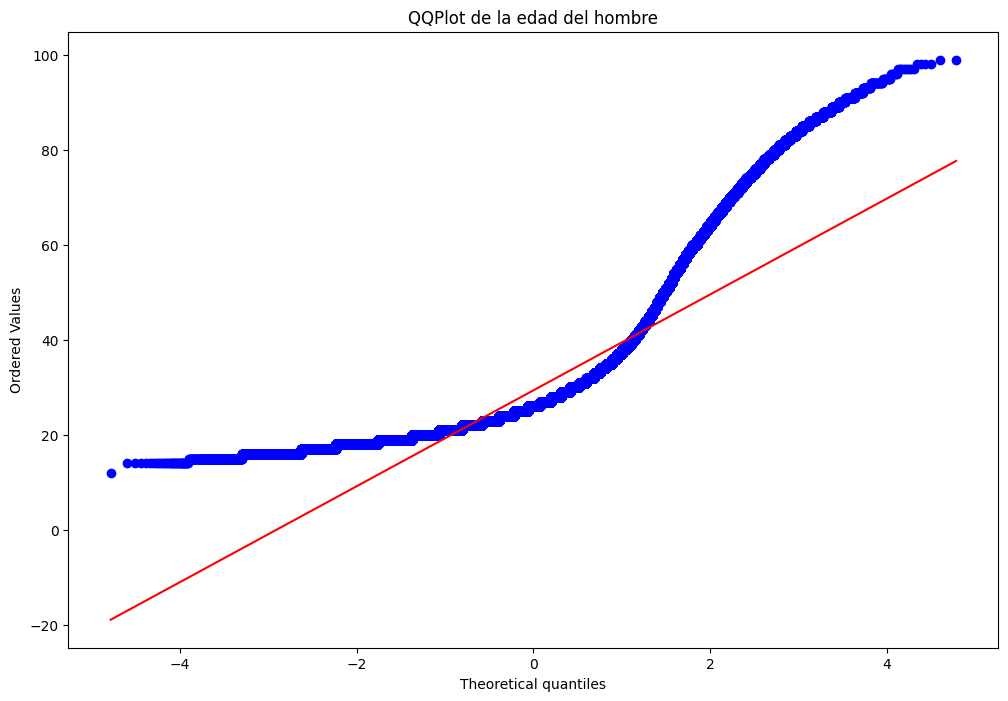

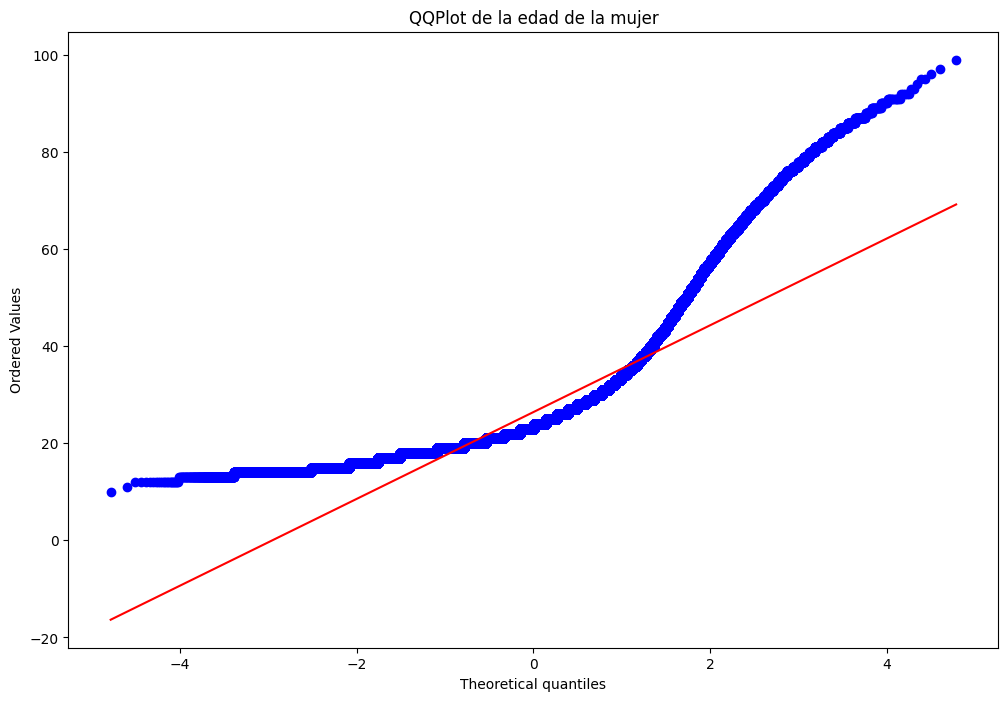

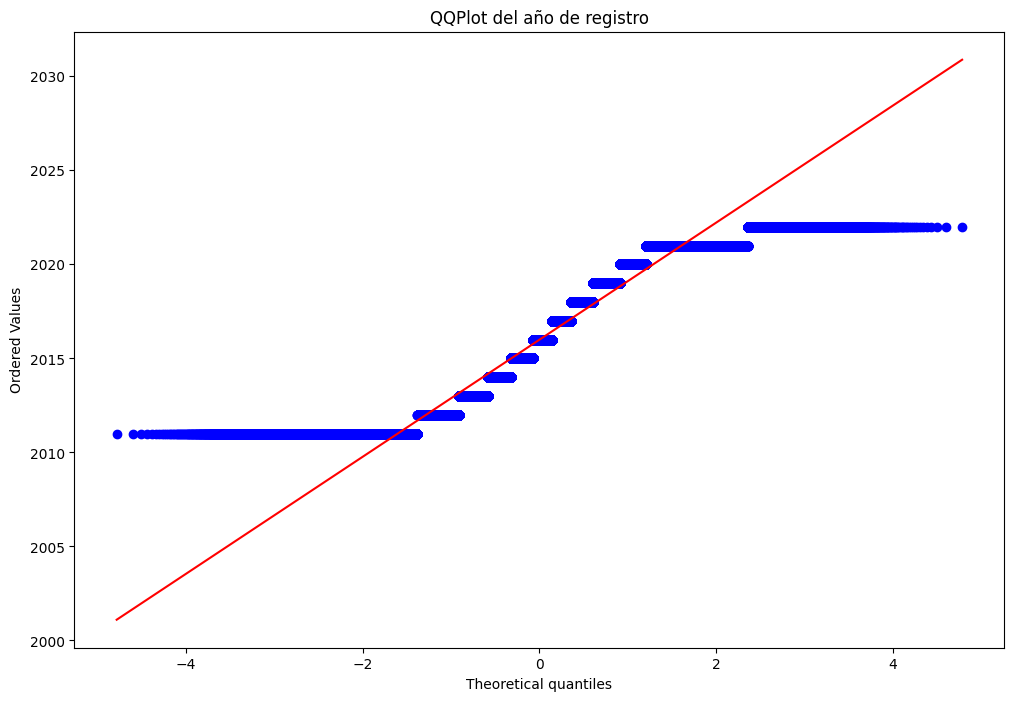

In [42]:
## qqplot de la edad del hombre# from scipy.stats import norm, probplot, kstest

# qqplot de la edad del hombre
fig, ax = plt.subplots(figsize=(12,8))
data_final['edadHombre'] = data_final['edadHombre'].astype(int)
stats.probplot(data_final['edadHombre'], plot=plt)
plt.title("QQPlot de la edad del hombre")
plt.show()

# qqplot de la edad de la mujer
fig, ax = plt.subplots(figsize=(12,8))
data_final['edadMujer'] = data_final['edadMujer'].astype(int)
stats.probplot(data_final['edadMujer'], plot=plt)
plt.title("QQPlot de la edad de la mujer")
plt.show()

# qqplot del año de registro
fig, ax = plt.subplots(figsize=(12,8))
data_final['anioRegistro'] = data_final['anioRegistro'].astype(int)
stats.probplot(data_final['anioRegistro'], plot=plt)
plt.title("QQPlot del año de registro")
plt.show()




In [24]:
# Se llevaran a cabo pruebas de normalidad con:
# *******Shapiro-Wilks*******

_, p_value = stats.shapiro(data_final[["ocupacionHombre"]].dropna())
print(f"Ocupacion Hombre: [p={p_value}]")

_, p_value = stats.shapiro(data_final[["educacionHombre"]].dropna())
print(f"Educacion Hombre: [p={p_value}]")

_, p_value = stats.shapiro(data_final[["grupoEtnicoHombre"]].dropna())
print(f"Grupo Etnico Hombre: [p={p_value}]")

_, p_value = stats.shapiro(data_final[["anioRegistro"]].dropna())
print(f"Año Registro: [p={p_value}]")

Ocupacion Hombre: [p=0.0]
Educacion Hombre: [p=0.0]
Grupo Etnico Hombre: [p=0.0]
Año Registro: [p=0.0]


c:\Users\sarap\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\sarap\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\sarap\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\sarap\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Luego del analisis se rechaza la hipótesis nula de que las variables siguen una distribución normal.